In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
KERNEL_TYPE = "se"
N_DIM = 2

In [3]:
DATA_DIR = Path().cwd().parent / "data"
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

df = pd.read_json(DATA_DIR / "benchmark_df.json")

se_data = df[df['kernel_type'] == KERNEL_TYPE].copy()

print(f"Loaded {len(se_data)} runs with SE kernel")
print(f"Unique combinations: {se_data.groupby(['acq_func', 'len_scale', 'n_dim']).ngroups}")
se_data

Loaded 2400 runs with SE kernel
Unique combinations: 24


,acq_func,kernel_type,len_scale,n_dim,run_id,y_true_max,final_y_max,y_max_history,steps
0,expected_improvement,se,1,1,0,2.495439,2.495439,"[1.8840306436, 1.9654384922, 1.9654384922, 1.9...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,expected_improvement,se,1,1,1,2.735978,2.735978,"[-0.0891494513, 0.0498287799, 0.0498287799, 0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,expected_improvement,se,1,1,2,2.485885,2.485885,"[2.159422303, 2.159422303, 2.4858852157, 2.485...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
3,expected_improvement,se,1,1,3,1.871820,1.871820,"[1.5459823409, 1.5459823409, 1.5459823409, 1.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4,expected_improvement,se,1,1,4,2.391196,2.391196,"[1.5211123056, 1.5211123056, 1.5211123056, 1.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
...,...,...,...,...,...,...,...,...,...
2395,random_search,se,100,2,95,1.303571,1.269504,"[1.0540014351, 1.0540014351, 1.0540014351, 1.0...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2396,random_search,se,100,2,96,0.561361,0.510470,"[0.4428448562, 0.4428448562, 0.4428448562, 0.4...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2397,random_search,se,100,2,97,-0.149389,-0.170156,"[-0.8277487237000001, -0.8277487237000001, -0....","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2398,random_search,se,100,2,98,0.872817,0.869438,"[0.5725875973, 0.5725875973, 0.5725875973, 0.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


In [4]:
se_data['regret'] = se_data.apply(lambda x: x['y_true_max'] - np.array(x['y_max_history']), axis=1)

# Explode the regret_history into separate rows
regret_df = se_data[['acq_func', 'len_scale', 'n_dim', 'run_id', 'regret']].copy()
regret_df = regret_df.explode('regret').reset_index(drop=True)
regret_df['step'] = regret_df.groupby(['acq_func', 'len_scale', 'n_dim', 'run_id']).cumcount()

# Convert regret to numeric and drop any NaN values
regret_df['regret'] = pd.to_numeric(regret_df['regret'], errors='coerce')
# regret_df = regret_df.dropna(subset=['regret'])

regret_df = regret_df[regret_df["n_dim"] == N_DIM]

# Group by acquisition function and step, compute mean and std
regret_stats = regret_df.groupby(['acq_func', 'step'])['regret'].agg(['mean', 'std']).reset_index()

print(f"Created regret history for {len(regret_df)} data points")
regret_stats

Created regret history for 56400 data points


,acq_func,step,mean,std
0,expected_improvement,0,1.038500,0.822394
1,expected_improvement,1,0.852087,0.825277
2,expected_improvement,2,0.744807,0.801980
3,expected_improvement,3,0.649634,0.766849
4,expected_improvement,4,0.588895,0.730926
...,...,...,...,...
89,random_search,42,0.270711,0.371659
90,random_search,43,0.266090,0.369033
91,random_search,44,0.264624,0.367304
92,random_search,45,0.261629,0.366034


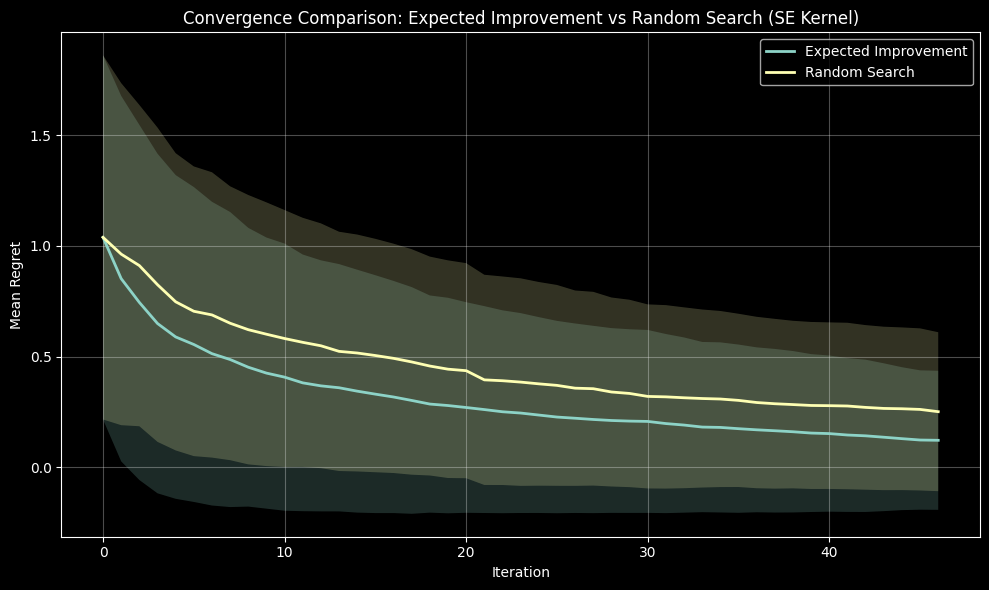

In [5]:
# Simple line plot with shaded std dev
fig, ax = plt.subplots(figsize=(10, 6))

acq_funcs = regret_stats.acq_func.unique().tolist()
for method in acq_funcs:
    data = regret_stats[regret_stats['acq_func'] == method]
    ax.plot(data['step'], data['mean'], label=method.replace('_', ' ').title(), linewidth=2)
    ax.fill_between(data['step'],
                    data['mean'] - data['std'],
                    data['mean'] + data['std'],
                    alpha=0.2)

ax.set_xlabel('Iteration')
ax.set_ylabel('Mean Regret')
ax.set_title('Convergence Comparison: Expected Improvement vs Random Search (SE Kernel)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()